# Indoor Scene Recognition using PyTorch

Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.

![Garbage Bins](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-61705-9_64/MediaObjects/500677_1_En_64_Fig1_HTML.png)


In this notebook we'll use PyTorch for classifying the indoor scene into various categories like bakery, casino, etc.

Let us start by importing the libraries:

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Let us see the classes present in the dataset:

# Database

The database contains 67 Indoor categories, and a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. The images provided here are for research purposes only.

In [2]:
data_dir  = '../input/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'

classes = os.listdir(data_dir)
print(classes)

['meeting_room', 'grocerystore', 'trainstation', 'mall', 'bar', 'auditorium', 'laboratorywet', 'florist', 'closet', 'livingroom', 'pantry', 'airport_inside', 'prisoncell', 'locker_room', 'elevator', 'dentaloffice', 'laundromat', 'fastfood_restaurant', 'casino', 'dining_room', 'kindergarden', 'concert_hall', 'waitingroom', 'bathroom', 'corridor', 'bedroom', 'hairsalon', 'kitchen', 'tv_studio', 'artstudio', 'library', 'inside_bus', 'restaurant_kitchen', 'inside_subway', 'buffet', 'bookstore', 'museum', 'lobby', 'gameroom', 'shoeshop', 'garage', 'poolinside', 'clothingstore', 'deli', 'subway', 'jewelleryshop', 'stairscase', 'toystore', 'classroom', 'restaurant', 'nursery', 'bakery', 'bowling', 'office', 'operating_room', 'warehouse', 'studiomusic', 'church_inside', 'computerroom', 'cloister', 'greenhouse', 'winecellar', 'gym', 'videostore', 'hospitalroom', 'children_room', 'movietheater']


In [3]:
len(classes)

67

## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


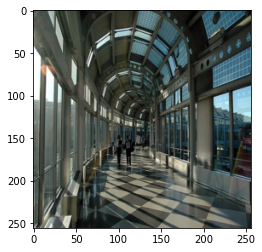

In [6]:
img, label = dataset[50]
show_sample(img, label)

# Loading and Splitting Data:

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [8]:
len(dataset)

15620

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [13000, 2000, 620])
len(train_ds), len(val_ds), len(test_ds)

(13000, 2000, 620)

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

Now, we'll create training and validation dataloaders using `DataLoader`.

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

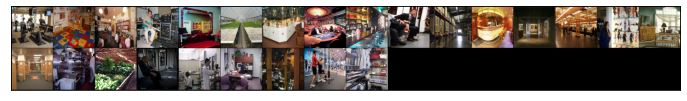

In [13]:
show_batch(train_dl)

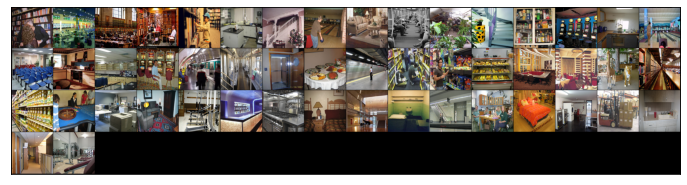

In [14]:
show_batch(val_dl)

# Model Base:

Let's create the model base:

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet18 for classifying images:

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Training the Model:

This is the function for fitting the model.

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_dl)

{'val_loss': 4.212893009185791, 'val_acc': 0.008499999530613422}

Let's start training the model:

In [23]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 6e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 3.7269, val_loss: 3.5229, val_acc: 0.5875
Epoch 2: train_loss: 3.4686, val_loss: 3.4408, val_acc: 0.6710
Epoch 3: train_loss: 3.3759, val_loss: 3.4084, val_acc: 0.7145
Epoch 4: train_loss: 3.3241, val_loss: 3.3950, val_acc: 0.7375
Epoch 5: train_loss: 3.2926, val_loss: 3.4007, val_acc: 0.7470
Epoch 6: train_loss: 3.2757, val_loss: 3.4077, val_acc: 0.7445
Epoch 7: train_loss: 3.2644, val_loss: 3.4089, val_acc: 0.7595
Epoch 8: train_loss: 3.2582, val_loss: 3.4088, val_acc: 0.7625
Epoch 9: train_loss: 3.2526, val_loss: 3.4156, val_acc: 0.7620
Epoch 10: train_loss: 3.2491, val_loss: 3.4250, val_acc: 0.7610


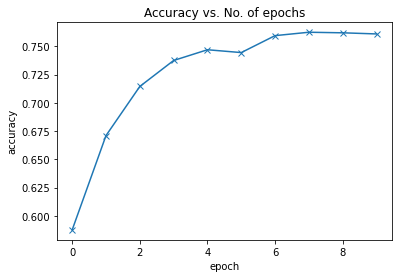

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

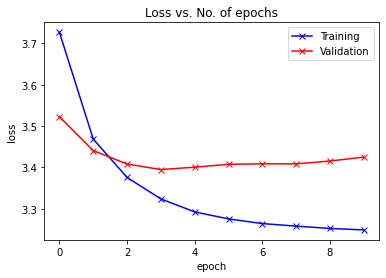

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
evaluate(model, val_dl)

{'val_loss': 3.4250130653381348, 'val_acc': 0.7610000371932983}

# Visualizing Predictions:

In [27]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Label: restaurant , Predicted: restaurant


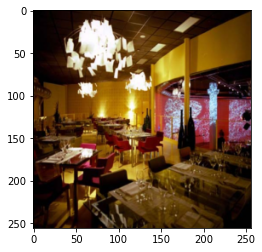

In [28]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: poolinside , Predicted: poolinside


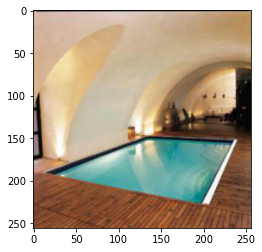

In [29]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bakery , Predicted: bakery


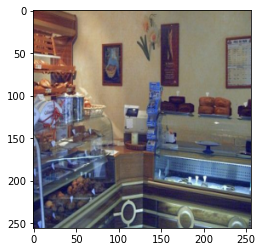

In [30]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [31]:
import urllib.request
urllib.request.urlretrieve("https://images.squarespace-cdn.com/content/v1/5a7497e29f8dcee376b70f7e/1591630503059-FBBWAYXPWYOK9BTIBMZY/ke17ZwdGBToddI8pDm48kA_SSaoz4elkj-HsZd8gX3Z7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UWPwZyNcweDIvdeL5kotwkIXjs9g0WibSO_cU-Ijy4Pwg6poS-6WGGnXqDacZer4yQ/74586587_10157705983079085_1307946016988725248_o+%281%29.jpg?format=2500w", "bar.jpg")
urllib.request.urlretrieve("https://www.bocadolobo.com/en/inspiration-and-ideas/wp-content/uploads/2018/03/Discover-the-Ultimate-Master-Bedroom-Styles-and-Inspirations-6_1.jpg", "bedroom.jpg")    
urllib.request.urlretrieve("https://sika.scene7.com/is/image/sika/glo-elevator-appliances?wid=1280&crop=0%2C80%2C4615%2C3212", "elevator.jpg") 
urllib.request.urlretrieve("https://i.pinimg.com/originals/2b/15/9d/2b159da035e4e3aaa30c03ec8ba7816c.jpg", "gameroom.jpg")
urllib.request.urlretrieve("https://i.pinimg.com/originals/a6/d9/d7/a6d9d743da7017a7bcf4a53e46d22f81.jpg", "inside_bus.jpg")
urllib.request.urlretrieve("https://s.wsj.net/public/resources/images/ON-CE927_moviet_B1280_20170714200426.jpg", "theatre.jpg")

('theatre.jpg', <http.client.HTTPMessage at 0x7f70ff929710>)

Let us load the model. You can load an external pre-trained model too!

In [32]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [33]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles bar.


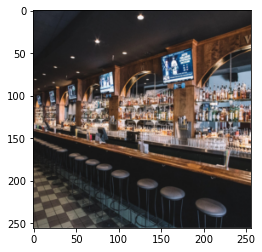

In [34]:
predict_external_image('bar.jpg')

The image resembles bedroom.


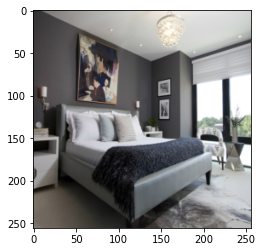

In [35]:
predict_external_image('bedroom.jpg')

The image resembles elevator.


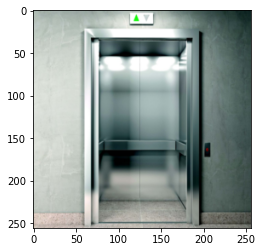

In [36]:
predict_external_image('elevator.jpg')

The image resembles studiomusic.


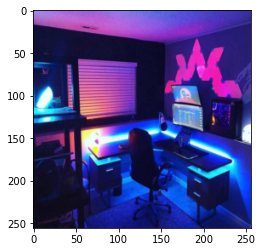

In [37]:
predict_external_image('gameroom.jpg')

The image resembles inside_subway.


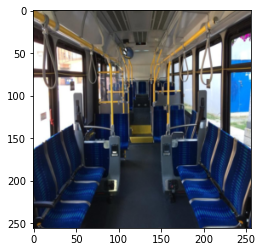

In [38]:
predict_external_image('inside_bus.jpg')

The image resembles movietheater.


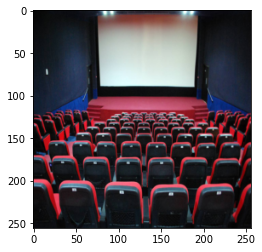

In [39]:
predict_external_image('theatre.jpg')

# Conclusion:

Our model is able to classify indoor with **76% accuracy (max)**!

It's great to see the model's predictions on the test set. It works pretty good on external images too!

You can try experimenting with more images and see the results!

### If you liked the kernel, don't forget to show some appreciation :)